## Подключение и конфигурация библиотеки

In [194]:
# Подключаем необходимые библиотеки
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt 
from volta.providers.boxes.box_binary import VoltaBoxBinary
from volta.core.validator import VoltaConfig
import queue

# конфигурируем python dict'ом
config = VoltaConfig(
    {
        'volta': {
            'type': 'binary',
            'source': '/dev/cu.wchusbserial1420',
            'power_voltage': 4800
        }
    }
)

# создаём объект класса VoltaBox
volta_box = VoltaBoxBinary(config)

## Запуск сбора данных

In [195]:
# создаём очередь для результатов
q = queue.Queue()

# и запускаем сбор данных
volta_box.start_test(q)  
 
# теперь можно делать любые действия с вашим телефоном, энергопотребление которых необходимо записать

# Данные собираются прямо сейчас!

In [196]:
# прочитаем одну секунду sample'ов из очереди для примера
one_sec = q.get_nowait()

one_sec.describe()

,value,uts
count,10000.000000,10000.000000
mean,115.767188,499950.000000
std,74.223401,288689.567991
min,0.000000,0.000000
25%,56.250000,249975.000000
50%,112.500000,499950.000000
75%,164.062500,749925.000000
max,482.812500,999900.000000


# Проводим тесты и останавливаем запись

In [197]:
# останавливаем сбор данных
volta_box.end_test()

# Сделаем несколько функций.
# Одна вычитывает из очереди данные и подготавливает их
# Вторая строит по подготовленным данным график тока


In [198]:
# сделаем функцию, которая забирает все накопленные данные из очереди и готовит их
def prepare_data():
    df = pd.DataFrame()
    for _ in range(q.qsize()):
        try:
            data = q.get_nowait()
            #data['uts'] = data['uts'] // 1000
            data.set_index(keys='uts', inplace=True, drop=True)
            df = df.append(data)
        except queue.Empty:
            pass
    return df

In [199]:
# сделаем функцию, которая строит график
def draw_plot(df, lines_tests, line_other):
    # украшательства для графика
    fig = plt.figure(figsize=(10, 8), dpi=100, linewidth=1)
    plt.style.use('seaborn-dark')
    plt.xlabel('nanoseconds')
    plt.ylabel('mA');
    plt.title('VoltaBox graph')

    # строим график тока
    plt.plot(df.index, df.values, color='darkblue', linestyle="-", linewidth=0.1)
    # считаем moving average
    rolling = df.rolling(500, win_type='hamming').mean()
    # строим график moving average
    plt.plot(rolling.index, rolling.values, color='red', label="moving average")
    
    for line in lines_tests:
        plt.axvline(line, color='yellow')
        
    for line in lines_other:
        plt.axvline(line, color='grey')
    
    plt.legend(loc='upper right')
    
# сделаем функцию, которая строит подробный график
def draw_detailed_plot(df):
    # украшательства для графика
    fig = plt.figure(figsize=(10, 8), dpi=100, linewidth=1)
    plt.style.use('seaborn-dark')
    plt.xlabel('milliseconds')
    plt.ylabel('mA');
    plt.title('VoltaBox graph')

    # строим график тока
    plt.plot(df.index, df.values, color='darkblue', linestyle="-", linewidth=1)    
    plt.legend(loc='upper right')
    
# сделаем функцию, которая строит подробный график
def draw_detailed_combined_plot(df, df2, df3):
    # украшательства для графика
    fig = plt.figure(figsize=(10, 8), dpi=100, linewidth=1)
    plt.style.use('seaborn-dark')
    plt.xlabel('milliseconds')
    plt.ylabel('mA');
    plt.title('VoltaBox graph')

    # строим график тока
    plt.plot(df.index, df.values, color='grey', linestyle="-", linewidth=1, label="first")    
    plt.plot(df2.index, df2.values, color='red', linestyle="-", linewidth=1, label="second") 
    plt.plot(df3.index, df3.values, color='darkblue', linestyle="-", linewidth=1, label="third")    
    plt.legend(loc='upper right')

# Строим график

In [200]:
# готовим данные
df = prepare_data()

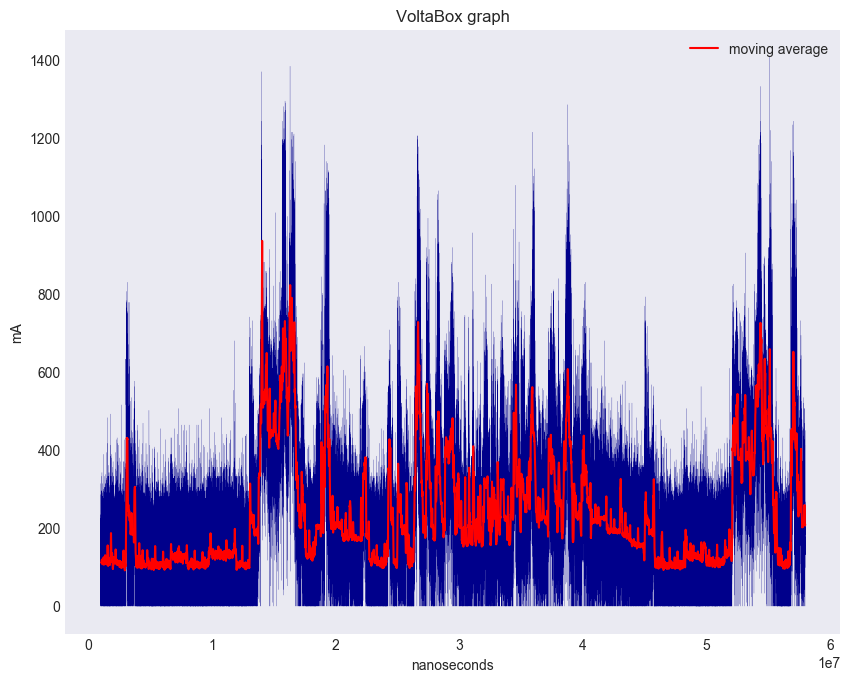

In [201]:
lines_other = []
draw_plot(df, [], [])

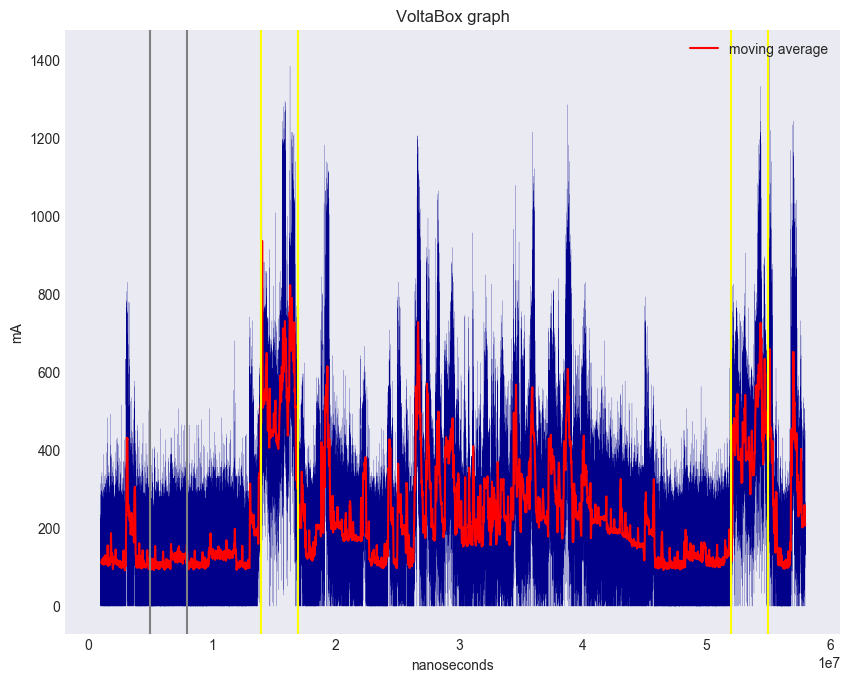

In [204]:
baseline_start = 5000000
baseline_end = baseline_start + 3000000
test1_start = 14000000
test1_end = test1_start + 3000000
test2_start = 52000000
test2_end = test2_start + 3000000

lines_tests = [test1_start, test1_end, test2_start, test2_end]
lines_other = [baseline_start, baseline_end]

# строим график
draw_plot(df, lines_tests, lines_other)

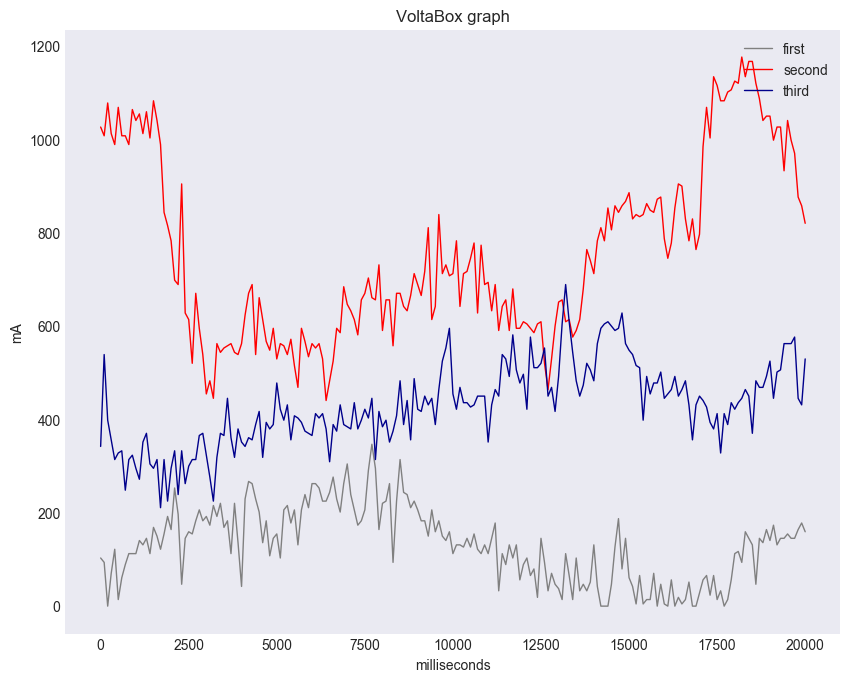

In [212]:
interval = 20000
diff = 2500000

baseline_interval_start = baseline_start+diff
baseline_interval_end = baseline_interval_start + interval
baseline_df = df.loc[baseline_interval_start:baseline_interval_end]
baseline_df.index = baseline_df.index.map(lambda x: ((x - baseline_interval_start)))

test1_interval_start = test1_start+diff
test1_interval_end = test1_interval_start + interval
test1_df = df.loc[test1_interval_start:test1_interval_end]
test1_df.index = test1_df.index.map(lambda x: ((x - test1_interval_start)))

test2_interval_start = test2_start+diff
test2_interval_end = test2_interval_start + interval
test2_df = df.loc[test2_interval_start:test2_interval_end]
test2_df.index = test2_df.index.map(lambda x: ((x - test2_interval_start)))

draw_detailed_combined_plot(baseline_df, test1_df, test2_df)


In [218]:
df_describe1 = pd.DataFrame().append(baseline_df)

df_describe1['test1'] = test1_df['value']
df_describe1['test2'] = test2_df['value']

df_describe1.describe()

,value,test1,test2
count,201.000000,201.00000,201.000000
mean,131.180037,757.04291,429.314366
std,78.949910,191.83855,87.748151
min,0.000000,440.62500,210.937500
25%,65.625000,595.31250,370.312500
50%,135.937500,703.12500,431.250000
75%,182.812500,876.56250,482.812500
max,346.875000,1176.56250,689.062500


In [219]:
df_describe1.quantile([.1,.5,.75,.8,.9,.95,.99])

,value,test1,test2
0.10,14.0625,543.7500,314.0625
0.50,135.9375,703.1250,431.2500
0.75,182.8125,876.5625,482.8125
0.80,206.2500,989.0625,501.5625
0.90,229.6875,1054.6875,553.1250
0.95,262.5000,1101.5625,590.6250
0.99,304.6875,1167.1875,609.3750


In [215]:
baseline_df_full = df.loc[baseline_start:baseline_end]
baseline_df_full.index = baseline_df_full.index.map(lambda x: ((x - baseline_start)))
test1_df_full = df.loc[test1_start:test1_end]
test1_df_full.index = test1_df_full.index.map(lambda x: ((x - test1_start)))
test2_df_full = df.loc[test2_start:test2_end]
test2_df_full.index = test2_df_full.index.map(lambda x: ((x - test2_start)))


df_describe_full = pd.DataFrame().append(baseline_df_full)

df_describe_full['test1'] = test1_df_full['value']
df_describe_full['test2'] = test2_df_full['value']

df_describe_full.describe()

,value,test1,test2
count,30001.000000,30001.000000,30001.000000
mean,116.780170,535.476213,441.545126
std,73.507346,174.266159,147.976397
min,0.000000,0.000000,0.000000
25%,60.937500,431.250000,351.562500
50%,112.500000,515.625000,431.250000
75%,168.750000,614.062500,520.312500
max,506.250000,1382.812500,1331.250000


In [220]:
df_describe_full.quantile([.1,.5,.75,.8,.9,.95,.99])

,value,test1,test2
0.10,14.0625,342.1875,281.2500
0.50,112.5000,515.6250,431.2500
0.75,168.7500,614.0625,520.3125
0.80,182.8125,651.5625,543.7500
0.90,215.6250,750.0000,609.3750
0.95,239.0625,853.1250,670.3125
0.99,295.3125,1106.2500,965.6250
